In [1]:
# import tensorflow.compat.v1 as tf
# from tensorflow.compat.v1 import keras
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imsave, imshow
import numpy as np
import pandas as pd
import math
from scipy.signal import convolve2d
import scipy.signal as ss
from scipy import ndimage
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras import Sequential
# from keras import layers
import time
import copy
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error as MSE
import gc
import os.path
gc.enable()

# from predict import main
# tf.keras.backend.clear_session()  # For easy reset of notebook state.
# sess = tf.Session() 
# keras.backend.set_session(sess)


def make_ker(ker_len, ker_angle):
#     h = ker_len * 2
    h = ker_len
    ker_len_ = ker_len // 2
    if ker_angle == 0:
        ker = np.zeros((h, h), dtype='float')
        ker[ker_len_] = 1
    elif ker_angle == 90 or ker_angle == 180:
        ker = make_ker(ker_len, 0)
        ker = ndimage.rotate(ker, ker_angle)
    else:
        L = 101
        H = L // 2
        multiplicator = H/ker_len_
        ker = np.zeros((L, L), dtype='float')
        #print(int(math.floor(H - multiplicator/ 2)), int(math.ceil(H + multiplicator/ 2)))
        ker[int(math.floor(H - multiplicator/ 2)) : int(math.ceil(H + multiplicator/ 2))] = 1
        rotated_img = ndimage.rotate(ker, ker_angle)
        sigma = 0.3 * np.sqrt(multiplicator**2 - 1)
        blurred = ndimage.gaussian_filter(rotated_img, sigma)
        ker = ndimage.interpolation.zoom(blurred, 1/multiplicator)
    ker /= ker.sum()
    return ker

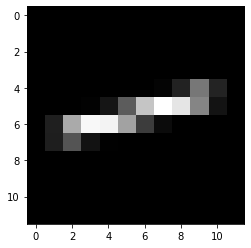

In [3]:
l = 11
a = 15
plt.imshow(make_ker(l, a), cmap='gray')
plt.imsave('ker_len-' + str(l) +  '_angle-' + str(a) + '.png', make_ker(l, a))

In [2]:
import random
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.util import random_noise

IMG_SIZE = 200
BLUR_LEN = 5
# IMG_SIZE = None
# OUT_SIZE = 600
BATCH_SIZE = 8
EPS = 10e-7

def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)

def prepare_img(img):
    image = copy.copy(img)
    if len(image.shape) == 2:
        image = np.stack((image, image, image))
        image = np.transpose(image, axes=(1,2, 0))
    for channel in range(3):
        image[:,:,channel] = (image[:,:,channel] - np.mean(image[:,:,channel])) / (np.std(image[:,:,channel]) + EPS)
    if (image.shape[2] == 4):
        image = image[:,:,:3]
    h, w = image.shape[:2]
    return image

def prepare_img1(img):
    image = copy.copy(img)
    if len(image.shape) == 2:
        image = np.stack((image, image, image))
        image = np.transpose(image, axes=(1,2, 0))
    if (image.shape[2] == 4):
        image = image[:,:,:3]
    return img_as_float(image)

from sklearn.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR

def calc_metrics(predicted_dir, target_dir, list_len = None):
    pred_files = listdir(predicted_dir)
    targ_files = listdir(target_dir)
    if (not list_len is None):
        pred_files = pred_files[:list_len]
    l = len(pred_files)
    metrics = dict()
    metrics['PSNR'] = 0
    metrics['SSIM'] = 0
    for idx in range(len(pred_files)):
        # print(pred_files[idx])
        p = prepare_img1(imread(os.path.join(predicted_dir, pred_files[idx]))[:600, :600])
        if (pred_files[idx] in targ_files):
            t = prepare_img1(imread(os.path.join(target_dir, pred_files[idx])))
        try:
            metrics['PSNR'] += PSNR(t,p)
            metrics['SSIM'] += SSIM(t,p, multichannel=True)
        except:
            l -= 1
            print('fovno')

    metrics['PSNR'] /= l
    metrics['SSIM'] /= l
    return metrics

In [4]:
def S(image, axis='x', offset=1, boundary='symm'):
    '''
    Offset operator of image along given axis
    '''
    if offset == 0:
        return image
    width = image.shape[1] 
    height = image.shape[0] 
    out_image = np.ndarray([height, width], dtype=float)
    if axis == 'x':
        if offset > 0:
            for i in range(offset):
                out_image[:, offset - i] = image[:, i]
            for i in range(offset, width):
                out_image[:, i] = image[:, i- offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[:, width - 1 - offset + i] = image[:, width - 1 - i]
            for i in range(width - 1 - offset):
                out_image[:, i] = image[:, i + offset]
    if axis == 'y':
        if offset > 0:
            for i in range(offset):
                out_image[offset - i] = image[i]
            for i in range(offset, height):
                out_image[i] = image[i - offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[height - 1 - offset + i] = image[height - 1 - i]
            for i in range(height - 1 - offset):
                out_image[i] = image[i + offset]
                
    return out_image

def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)
        

class FunctionalMinimisation:
    '''
    Z_alpha = arg min(||Az - u||_1 + TV[z])
    
    grad(Z_alpha) = 2A^T(Az-u) + mult * D(TV[z])
    '''
    def __init__(self, image, kernel, beta_list):
        self._init_image = copy.deepcopy(image)
        self._cur_image = FixImage(copy.deepcopy(image))
        self.kernel = copy.deepcopy(kernel)
        
        self._left_grad = 0
        self._reg_grad = 0
        
        self._betas = beta_list
        self._mu = 0.85
        self._v = 0
        return
        
    def _sign_map(self, image, x_offset, y_offset):
        '''
        For derivative of Total Variation
        '''
        return np.sign(S(S(image, axis='x', offset=x_offset), axis='y', offset=y_offset) - image)

    def _offset_image(self, image, x_offset, y_offset):
        '''
        Returns image, shifted in x_offset pixels along X and in y_offset pixels along Y
        '''
        return S(S(image, axis='x', offset = x_offset), axis='y', offset = y_offset)
    
    def _count_gradient(self):
        
        Q = [[1, 0], [0, 1], [1, 1], [1, -1]]
    
        reg_grad = 0
        
        for cur_Q in Q:
            a = self._sign_map(self._cur_image + self._mu * self._v, cur_Q[0], cur_Q[1])
#             a = self._sign_map(self._cur_image, cur_Q[0], cur_Q[1])
            reg_grad += (1/math.sqrt(cur_Q[0]**2 + cur_Q[1]**2)) *\
                (self._offset_image(a, - cur_Q[0], - cur_Q[1]) - a)

        self._reg_grad = reg_grad
        self._left_grad = 2 * ss.convolve2d(ss.convolve2d(
                                                    self._cur_image + self._mu * self._v,
                                                    self.kernel,
                                                    mode='same',
                                                    boundary='symm')\
                                                - self._init_image,\
                                                self.kernel,
                                                mode='same',
                                                boundary='symm')
        return
        
    def _count_v(self, beta = 1):
        '''
        Nesterov accelerated gradient(II variant in presentation)
        g_k = grad(f(z_k + mu * v_k))
        v_(k+1) = mu * v_k - beta_k * g_k
        z_(k+1) = z_k + v_(k+1)
        '''
        mult = 0.5
        reg_mult = 0.001
        self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
        
    def _update_image(self):
        self._cur_image += self._v
        
    def MainProcess(self):
        t = time.time()
        for idx, i in enumerate(self._betas):
            self._count_gradient()
            self._count_v(i)
            self._update_image()
        return self._cur_image

In [5]:
import random

In [6]:
IMG_SIZE = 600
BLUR_LEN = 10
# KER = make_ker(BLUR_LEN, 0)
global_idx = 0

def generate_pics(paths, amount_on_picture, ker, save_dir, break_on = 0):
    global_idx = 0
    for p in paths:
        try:
            cur_img = prepare_img1(imread(p))
            blurred = convolve_img(cur_img, ker)
            noised = random_noise(blurred, var=0.0005)
            h, w = cur_img.shape[:2]
            if (h > IMG_SIZE and w > IMG_SIZE):
                for idx in range(amount_on_picture):
                    y = random.randrange(h - IMG_SIZE)
                    x = random.randrange(w - IMG_SIZE)
                    plt.imsave(save_dir + 'bn/img_' + str(global_idx) + '.png',  noised[y : y + IMG_SIZE, x : x + IMG_SIZE])
                    plt.imsave(save_dir + 'sn/img_' + str(global_idx) + '.png', cur_img[y : y + IMG_SIZE, x : x + IMG_SIZE])
                    global_idx += 1
            if (break_on != 0):
                if (break_on == global_idx):
                    return
        except:
            pass

def generate_low(paths, ker, save_dir = ''):
    global_idx = 0
    for p in paths:
        # try:

            cur_img = prepare_img1(imread(p))
            blurred = convolve_img(cur_img, ker)
            noised = random_noise(blurred, var=0.001)
            h, w = cur_img.shape[:2]
            plt.imsave(save_dir + '/img_' + str(global_idx) + '.png', noised)
            global_idx += 1
           
        # except:
            # pass


def generate_pics_from_two(paths_X, paths_y, amount_on_picture):
    global_idx = 0
    for p in range(len(paths_X)):
        blurred = prepare_img1(imread(paths_X[p]))
        cur_img = prepare_img1(imread(paths_y[p]))
        h, w = cur_img.shape[:2]
        for idx in range(amount_on_picture):
            y = random.randrange(h - IMG_SIZE)
            x = random.randrange(w - IMG_SIZE)
            plt.imsave('pict/b_test/test_' + str(global_idx) + '.png', blurred[y : y + IMG_SIZE, x : x + IMG_SIZE])
            plt.imsave('pict/s_test/test_' + str(global_idx) + '.png', cur_img[y : y + IMG_SIZE, x : x + IMG_SIZE])
            global_idx += 1
    return

def convolve_img(image, ker):
    # ker = KER
        ker_len = ker.shape[0]
        pad = ker_len // 2
        img = image
        if len(img.shape) == 2:
            img = np.stack((image, image, image))
            img = np.transpose(image, axes=(1,2, 0))
        # for channel in range(3):
            # image[:,:,channel] = (image[:,:,channel] - np.mean(image[:,:,channel])) / (np.std(image[:,:,channel]) + EPS)
        r = convolve2d(np.pad(img[:,:,0], pad, 'edge'), ker, mode='valid'); #r /= r.max()
        g = convolve2d(np.pad(img[:,:,1], pad, 'edge'), ker, mode='valid'); #g /= g.max()
        b = convolve2d(np.pad(img[:,:,2], pad, 'edge'), ker, mode='valid'); #b /= b.max()
        image = np.stack((r, g, b))
        image = np.clip(image, 0., 1.)
        image = np.transpose(image, axes=(1,2, 0))
        return image

def make_directory(dirname):
    if (not os.path.exists(dirname)):
        os.mkdir(dirname)
    return 

In [7]:
R = 0
G = 0
B = 0

def restore_img(img, kernel, betas= list([0.5 / np.sqrt(k) for k in range(1, 60)])):
    pad = kernel.shape[0] // 2
    global R, G, B
    r = np.pad(img[:,:,0], pad, mode='edge')
    g = np.pad(img[:,:,1], pad, mode='edge')
    b = np.pad(img[:,:,2], pad, mode='edge')
    
    func_min = FunctionalMinimisation(r, kernel, betas)
    r = func_min.MainProcess()
    func_min = FunctionalMinimisation(g, kernel, betas)
    g = func_min.MainProcess()
    func_min = FunctionalMinimisation(b, kernel, betas)
    b = func_min.MainProcess()

    R = r; G = g; B = b

    image = np.stack((r, g, b))
    image = np.clip(image, 0., 1.)
    image = np.transpose(image, axes=(1,2, 0))

    return image[pad : pad + img.shape[0], pad : pad + img.shape[1], :]

def restore_img_p(path, kernel):
    return restore_img(prepare_img1(plt.imread(path)), kernel)

In [32]:
    fig.savefig(os.path.join('different_betas'))

In [34]:
orig = prepare_img1( plt.imread('.\MyStuff\ds\l_11\sn\img_0.png'))
nn_old = prepare_img1( plt.imread('.\MyStuff\\results\dates\\04_19\img_0o.png'))
nn_new = prepare_img1( plt.imread('.\MyStuff\\results\dates\\04_19\img_0.png'))

In [8]:
def restore_folder(ker, paths, fnames, save_dir):
    for cur_p, fname in zip(paths, fnames):
        plt.imsave(save_dir + fname, restore_img_p(cur_p, ker))

In [9]:
%%time
amount_of_picts = 7000
train_dir = '../Diploma/pict/google_initial/'
# y_dir = 'pict/random_la/s_low/'
# y_dir = 'pict/google_initial/'
save_dir = './MyStuff/ds/'
# train_dir = 'b/'
# y_dir = 'pict/s_/'
# y_dir = 's/'
fnames_X = listdir(train_dir)
random.shuffle(fnames_X)
# fnames_y = listdir(y_dir)

# X = list([train_dir + item for item in fnames_X])
X = list([train_dir + item for item in fnames_X])[:amount_of_picts]
# y = list([y_dir + item for item in fnames_y])

Wall time: 2.1 s


In [10]:
ker = make_ker(10, 0)
dirname = 'pict/random_la/b_low/'
generate_low(y, ker, dirname)

In [12]:
fnames_X = listdir(dirname)
X = list([os.path.join(dirname, item) for item in fnames_X])
restored_save = 'pict/random_la/b_low_restored/'
restore_folder(ker, X, fnames_X, restored_save)

In [9]:
%%time
# ker_lens = [3, 5, 7, 11]
ker_lens = [7]
for l in ker_lens:
    fnames_X = listdir(train_dir)
    random.shuffle(fnames_X)
    X = list([train_dir + item for item in fnames_X])[:amount_of_picts]
    ker = make_ker(l, 0)
    make_directory(save_dir + 'l_' + str(l) + '/')
    make_directory(save_dir + 'l_' + str(l) + '/bn/')
    make_directory(save_dir + 'l_' + str(l) + '/sn/')
    generate_pics(X, 1, ker, save_dir + 'l_' + str(l) + '/')

Wall time: 2h 12min 36s


In [15]:
%%time
# for k in ker_lens:
for idx, l in enumerate(ker_angles):
    ker = make_ker(10, l)
    dirname = os.path.join(save_dir, 'angle_' + str(angles[idx]))
    fnames_X = listdir(dirname)
    X = list([os.path.join(dirname, item) for item in fnames_X])
    restored_save =  dirname + '_restored/'
    if (not os.path.exists(restored_save)):
        os.mkdir(restored_save)

Wall time: 2h 43min 41s


In [14]:
metrics_orig = calc_metrics('pict/random_la/b_low/', 'pict/random_la/s_ordered/')
metrics_restored = calc_metrics('pict/random_la/b_low_restored/', 'pict/random_la/s_ordered/')
metrics_pred = calc_metrics('pict/random_la/b_low_pred/', 'pict/random_la/s_ordered/')

In [16]:
print(metrics_orig)
print(metrics_restored)
print(metrics_pred)

{'PSNR': 23.809522020281502, 'SSIM': 0.6875503176774013}
{'PSNR': 23.241697715117187, 'SSIM': 0.6734156664649582}
{'PSNR': 26.455515786037715, 'SSIM': 0.7845010201526083}


In [ ]:
m0 = calc_metrics('pict/bn_val', 'pict/sn_val')

In [9]:
m1 = calc_metrics('pict/sn_val', 'result/bn_val_orig')

In [10]:
m2 = calc_metrics('pict/sn_val', 'result/bn_val_6')

In [11]:
m3 = calc_metrics('pict/sn_val', 'result/bn_val_20')

In [31]:
m4 = calc_metrics('pict/sn_val', 'pict/predicted_val')

In [33]:
m5 = calc_metrics('pict/sn_val', 'pict/predicted_val1')

In [30]:
print('Метрики на датасете:')
print('Сравнение размытых изображений с изначальными:')
print('  ' + str(m0))
print('Восстановленные Inception без дообучения:')
print('  ' + str(m1))
print('Восстановленное Inception после дообучения (6 эпох):')
print('  ' + str(m2))
print('Восстановленное Inception после дообучения (20 эпох):')
print('  ' + str(m3))

Метрики на датасете:
Сравнение размытых изображений с изначальными:
  {'PSNR': 23.425286662747613, 'SSIM': 0.6817486902035588}
Восстановленные Inception без дообучения:


NameError: name 'm1' is not defined

Text(0, 0.5, 'PSNR')

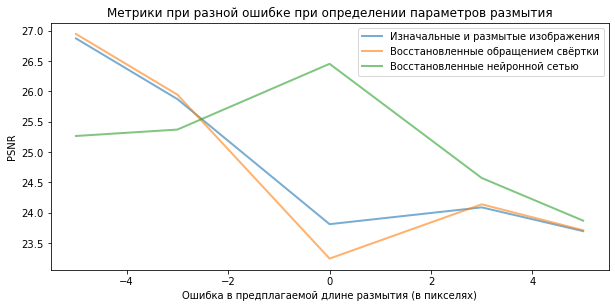

In [23]:
lens = [5, 7, 13, 15]
lens_mod = [-5, -3,0, 3, 5]
angles = [0, 10, 20, 30 ,40]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
lines = []

line_orig, = ax1.plot(lens_mod, [a['PSNR'] for a in orig_l],  lw=2, alpha=0.6)
line_dec,  = ax1.plot(lens_mod, [a['PSNR'] for a in dec_l],  lw=2, alpha=0.6)
line_nn,  = ax1.plot(lens_mod,  [a['PSNR'] for a in nn_l],    lw=2, alpha=0.6)
# ax1.set_xscale('log')

lines.append(line_orig)
lines.append(line_dec)
lines.append(line_nn)

ax1.legend(lines, ['Изначальные и размытые изображения', 'Восстановленные обращением свёртки', 'Восстановленные нейронной сетью'])

ax1.set_title('Метрики при разной ошибке при определении параметров размытия')
ax1.set_xlabel('Ошибка в предплагаемой длине размытия (в пикселях)')
ax1.set_ylabel('PSNR')

Text(0, 0.5, 'SSIM')

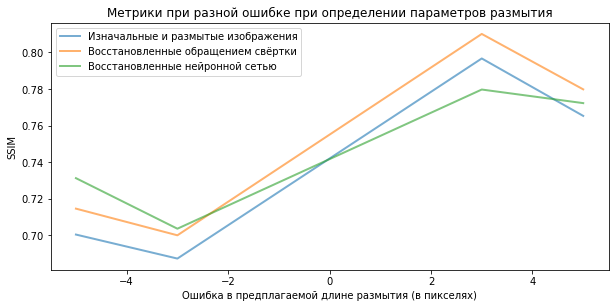

In [41]:
angles = [0, 10, 20, 30 ,40]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
lines = []

line_orig, = ax1.plot(lens_mod, [a['SSIM'] for a in orig_l],  lw=2, alpha=0.6)
line_dec,  = ax1.plot(lens_mod, [a['SSIM'] for a in dec_l],  lw=2, alpha=0.6)
line_nn,  = ax1.plot(lens_mod,  [a['SSIM'] for a in nn_l],    lw=2, alpha=0.6)
# ax1.set_xscale('log')

lines.append(line_orig)
lines.append(line_dec)
lines.append(line_nn)

ax1.legend(lines, ['Изначальные и размытые изображения', 'Восстановленные обращением свёртки', 'Восстановленные нейронной сетью'])

ax1.set_title('Метрики при разной ошибке при определении параметров размытия')
ax1.set_xlabel('Ошибка в предплагаемой длине размытия (в пикселях)')
ax1.set_ylabel('SSIM')

Text(0, 0.5, 'PSNR')

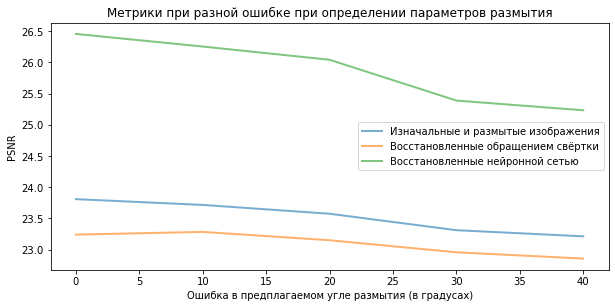

In [42]:
lens = [5, 7, 13, 15]
lens_mod = [-5, -3, 3, 5]
angles = [0, 10, 20, 30 ,40]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
lines = []

line_orig, = ax1.plot(angles, [a['PSNR'] for a in orig_a],  lw=2, alpha=0.6)
line_dec,  = ax1.plot(angles, [a['PSNR'] for a in dec_a],  lw=2, alpha=0.6)
line_nn,  = ax1.plot(angles,  [a['PSNR'] for a in nn_a],    lw=2, alpha=0.6)
# ax1.set_xscale('log')

lines.append(line_orig)
lines.append(line_dec)
lines.append(line_nn)

ax1.legend(lines, ['Изначальные и размытые изображения', 'Восстановленные обращением свёртки', 'Восстановленные нейронной сетью'])

ax1.set_title('Метрики при разной ошибке при определении параметров размытия')
ax1.set_xlabel('Ошибка в предплагаемом угле размытия (в градусах)')
ax1.set_ylabel('PSNR')

c:\Repos\DeblurGANv2\predict.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(cfg)
  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\CV\lib\site-packages\torch\nn\functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [10]:
orig_img = prepare_img1(plt.imread("../Diploma/pict/random_la/s_ordered/img_19.png"))
save_dir_plots = 'MyStuff/results/dates/04_19/plots'

save_dir0 = 'MyStuff/results/dates/04_19/blurred'
save_dir1 = 'MyStuff/results/dates/04_19/deconv'
save_dir2 = 'MyStuff/results/dates/04_19/nn_restored'

In [21]:
blurred_metrics = dict()
fnames = os.listdir(save_dir0)
for name in fnames:
    cur_blurred = prepare_img1(plt.imread(os.path.join(save_dir0, name)))[:600, :600]
    # print(cur_blurred.shape)
    # print(orig_img.shape)
    metrics = dict()
    metrics['PSNR'] = PSNR(orig_img, cur_blurred)
    metrics['SSIM'] = SSIM(orig_img, cur_blurred, multichannel=True)
    blurred_metrics[name] = metrics

In [22]:
deconv_metrics = dict()
fnames = os.listdir(save_dir1)
for name in fnames:
    cur_blurred = prepare_img1(plt.imread(os.path.join(save_dir1, name)))[:600, :600]
    # print(cur_blurred.shape)
    # print(orig_img.shape)
    metrics = dict()
    metrics['PSNR'] = PSNR(orig_img, cur_blurred)
    metrics['SSIM'] = SSIM(orig_img, cur_blurred, multichannel=True)
    deconv_metrics[name] = metrics

In [25]:
nn_metrics = dict()
fnames = os.listdir(save_dir2)
for name in fnames:
    cur_blurred = prepare_img1(plt.imread(os.path.join(save_dir2, name)))[:600, :600]
    metrics = dict()
    metrics['PSNR'] = PSNR(orig_img, cur_blurred)
    metrics['SSIM'] = SSIM(orig_img, cur_blurred, multichannel=True)
    nn_metrics[name] = metrics

In [15]:
metrics = dict()
for l in lens:
    # for a in angles:
        # for n_sigma in n_sigmas:
            blurred_arr = [blurred_metrics[a] for a in blurred_metrics if ('_l' + str(l)) in a]
            deconv_arr = [deconv_metrics[a] for a in deconv_metrics if ('_l' + str(l)) in a]
            nn_arr = [nn_metrics[a] for a in nn_metrics if ('_l' + str(l)) in a]
            metrics['_l' + str(l)] = (blurred_arr, deconv_arr, nn_arr)

NameError: name 'blurred_metrics' is not defined

In [10]:
lens = [3, 5, 7, 9, 11, 13]
angles = [0, 10, 20, 30, 40]
n_sigmas = [0.001, 0.0005, 0.0001]
n_sigma = n_sigmas[1] 
result_dict = dict()

In [37]:


RESTORE_KER = make_ker(10, 0)

for l in lens:
    for a in angles:
        # for n_sigma in n_sigmas:
            img_postfix = '_l' + str(l) + '_a' + str(a) + '_n' + str(n_sigma) + '.png'
            conv_ker = make_ker(l, a)
            blurred = convolve_img(orig_img, conv_ker)
            noised = random_noise(blurred, var=n_sigma)
            # nn_restored = nn_predict(noised)
            if (not os.path.exists(save_dir0)):
                os.mkdir(save_dir0)
            plt.imsave(os.path.join(save_dir0, 'blurred' + img_postfix), noised)
            restored = restore_img(noised, RESTORE_KER)
            if (not os.path.exists(save_dir1)):
                os.mkdir(save_dir1)
            plt.imsave(os.path.join(save_dir1, 'dec' + img_postfix), restored)
            # plt.imsave(nn_restored, os.path.join(save_dir, 'nn' + img_postfix))
            try:
                metrics = dict()
                metrics['PSNR'] = PSNR(orig_img, restored)
                metrics['SSIM'] = SSIM(orig_img, restored, multichannel=True)
                # metrics_nn = dict()
                # metrics_nn['PSNR'] = PSNR(orig_img, nn_restored)
                # metrics_nn['SSIM'] = SSIM(orig_img, nn_restored, multichannel=True)
            except:
                print('fovno')
            if metrics:
                result_dict['dec' + img_postfix] = metrics
                # result_dict['nn' + img_postfix] = metrics_nn
            

fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno
fovno


In [22]:
for l in lens:
    for a in angles:
        # for n_sigma in n_sigmas:
            # a = 0
            # l = 0
            n_sigma = 0.0005
            img_postfix = '_l' + str(l) + '_a' + str(a) + '_n' + str(n_sigma) + '.png'
            conv_ker = make_ker(l, a)
            blurred = convolve_img(orig_img, conv_ker)
            noised = random_noise(blurred, var=n_sigma)
            # nn_restored = nn_predict(noised)
            if (not os.path.exists(save_dir0)):
                os.mkdir(save_dir0)
            plt.imsave(os.path.join(save_dir0, 'blurred' + img_postfix), noised)

In [28]:
plt.imsave(os.path.join(save_dir, 'dec' + img_postfix), restored.astype(np.float64))

In [10]:
from predict import main
main(img_pattern=".\\MyStuff\\results\\dates\\04_09\\blurred\\*", weights_path='best_fpn.h5', out_dir='.\\MyStuff\\results\\dates\\04_09\\nn_restored\\')

c:\Repos\DeblurGANv2\predict.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(cfg)
  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\CV\lib\site-packages\torch\nn\functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


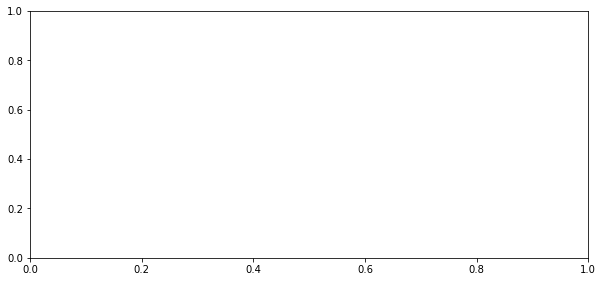

In [48]:
lens = [5, 7, 10, 13, 15]
lens_mod = [-5, -3, 0, 3, 5]
angles = [0, 10, 20, 30, 40]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
lines = []
metric = 'SSIM'
for num, cur_len in enumerate(lens):
    # key = '_l' + str(lens[num])

    # line_orig, = ax1.plot(angles, [a[metric] for a in metrics[key][0]],  lw=2, alpha=0.6)
    line_dec,  = ax1.plot(angles, [a[metric] for a in metrics[key][1]],  lw=2, alpha=0.6)
    line_nn,  = ax1.plot(angles,  [a[metric] for a in metrics[key][2]],    lw=2, alpha=0.6)
    # ax1.set_xscale('log')

    lines.append(line_orig)
    lines.append(line_dec)
    lines.append(line_nn)

    ax1.legend(lines, ['Изначальные и размытые изображения', 'Восстановленные обращением свёртки', 'Восстановленные нейронной сетью'])

    ax1.set_title('Метрики при разной ошибке (при зафиксированной длине размытия в ' + str(lens[num])+ ')')
    ax1.set_xlabel('Ошибка в предплагаемом угле размытия (в градусах)')
    ax1.set_ylabel(metric)

    plt.savefig(os.path.join(save_dir_plots, metric + key))
    plt.cla()

In [73]:
save_dir1 = 'MyStuff/results/dates/04_19/deconv'
deconv_dir = '.\\MyStuff\\results\\dates\\04_19\\blurred\\a0\\'
lens = [3, 5, 7, 9, 11, 13]
paths = os.listdir(deconv_dir)
for l in lens:
    local_save_dir = os.path.join(deconv_dir, 'l'+str(l))
    make_directory(local_save_dir)
    for p in paths:
        ker = make_ker(l, 0)
        # plt.imsave(os.path.join(local_save_dir, p), restore_img_p(deconv_dir+p, ker))


In [38]:
result_deconv = dict()
for idx in [7]:
    another_dir = 'MyStuff/results/dates/04_19/deconv/l' + str(idx)
    metrics = dict()
    paths = os.listdir(another_dir)
    for name in paths:
        cur_blurred = prepare_img1(plt.imread(os.path.join(another_dir, name)))[:600, :600]
        local_m = dict()
        local_m['PSNR'] = PSNR(orig_img, cur_blurred)
        local_m['SSIM'] = SSIM(orig_img, cur_blurred, multichannel=True)
        metrics[str(int(name[9:11]) - idx)] = local_m
    result_deconv[idx] = metrics

In [39]:
result_nn = dict()
for idx in ['07']:
    another_dir = 'MyStuff/results/dates/04_19/nn/l' + idx
    metrics = dict()
    paths = os.listdir(another_dir)
    for name in paths:
        cur_blurred = prepare_img1(plt.imread(os.path.join(another_dir, name)))[:600, :600]
        local_m = dict()
        local_m['PSNR'] = PSNR(orig_img, cur_blurred)
        local_m['SSIM'] = SSIM(orig_img, cur_blurred, multichannel=True)
        metrics[str(int(name[9:11]) - int(idx))] = local_m
    result_nn[idx] = metrics

In [50]:
nn_keys = list(result_nn['07'])
nn_values = [result_nn['07'][key] for key in nn_keys]

In [52]:
dec_keys = list(result_deconv[7])
dec_values = [result_deconv[7][key] for key in dec_keys]

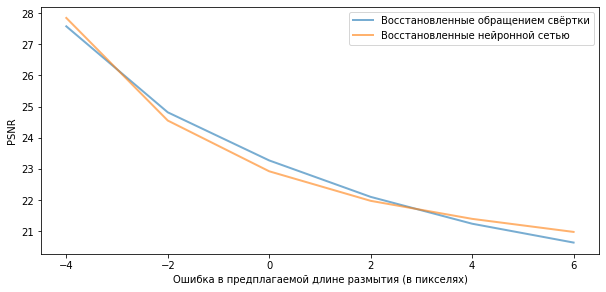

In [71]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
lines = []
metric = 'PSNR'
# for num, cur_len in enumerate(dec_keys):

line_dec,  = ax1.plot([int(a) for a in dec_keys], [v[metric] for v in dec_values],  lw=2, alpha=0.6)
line_nn,  = ax1.plot([int(a) for a in dec_keys],  [v[metric] for v in nn_values],    lw=2, alpha=0.6)

lines.append(line_dec)
lines.append(line_nn)

ax1.legend(lines, ['Восстановленные обращением свёртки', 'Восстановленные нейронной сетью'])

# ax1.set_title('Метрики при разной ошибке (при зафиксированной длине размытия в ' + str(dec_keys[num])+ ')')
ax1.set_xlabel('Ошибка в предплагаемой длине размытия (в пикселях)')
ax1.set_ylabel(metric)

plt.savefig(os.path.join('.', metric))
# plt.cla()